In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
from datetime import datetime as dt
import math as m

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
def get_data(query):
    import config
    config=config.config_sqlserver()
    conn = pyodbc.connect(*config)

    c=conn.cursor()
    c.execute(query)
    data=c.fetchall()
    conn.close()
    return data

In [3]:
ticker_list = get_data("Select distinct ticker from us_stage1")
stock_list = []
for l in ticker_list:
    stock_list.append(l[0])

In [161]:
#Create data frame
#Use three stocks to save time
import config
config=config.config_sqlserver()
conn = pyodbc.connect(*config)

stock_list = ['AAPL','GOOG','AMZN']
for stock in stock_list:
    sql = "SELECT * from us_stage1 where ticker= '%s' order by 'date' asc" % stock 
    ###Important if wanting sort for rolling, it must be sort by index. So grab data by order you want
    globals()[stock] = pd.read_sql(sql, conn)
conn.close()

In [162]:
#Another way to calculate Moving Average  
def MA(df, n):  
    name = 'MA ' + str(n) + ' Days'
    df[name] = pd.Series.rolling(df['adj_close'], n).mean() 
    return df

#Commodity Channel Index  
def CCI(df, n):  
    PP = (df['high'] + df['low'] + df['adj_close']) / 3  
    name = 'CCI_' + str(n)
    df[name] = pd.Series((PP - pd.Series.rolling(PP, n).mean()) / (0.015*pd.Series.rolling(PP, n).std()))   
    return df

# Compute the Bollinger Bands 
def BBANDS(df, ndays):
    MA = pd.Series.rolling(df['adj_close'], ndays).mean()
    SD = pd.Series.rolling(df['adj_close'], ndays).std()
    
    b1 = MA + (2 * SD)
    name1 = 'Upper BollingerBand'
    df[name1] = pd.Series(b1)
    
    b2 = MA - (2 * SD)
    name2 = 'Lower BollingerBand'
    df[name2] = pd.Series(b2)
    
    return df

In [163]:
AAPL.tail()

,ticker,date,open,high,low,close,volume,adj_close
783,AAPL,2017-02-10,132.460007,132.940002,132.050003,132.119995,20065500.0,132.119995
784,AAPL,2017-02-13,133.080002,133.820007,132.750000,133.289993,23035400.0,133.289993
785,AAPL,2017-02-14,133.470001,135.089996,133.250000,135.020004,32815500.0,135.020004
786,AAPL,2017-02-15,135.520004,136.270004,134.619995,135.509995,35501600.0,135.509995
787,AAPL,2017-02-16,135.669998,135.899994,134.839996,135.350006,22118000.0,135.350006


In [164]:
#This function is to get the stocks meeting requirement on the max date in the dateset
def model1(stock_list, ma1=5,ma2=10,ma3=20,ma4=30,cci_n=20,bband_n=30):
    for stock in stock_list:
        stock_df = globals()[stock]
        stock_df = MA(stock_df, ma1)
        stock_df = MA(stock_df, ma2)
        stock_df = MA(stock_df, ma3)
        stock_df = MA(stock_df, ma4)
        stock_df = CCI(stock_df, cci_n)
        stock_df = BBANDS(stock_df, bband_n)
        name1='MA '+ str(ma1) +' Days'
        p1 = stock_df[name1][ma1-1]
        name2='MA '+ str(ma2) +' Days'
        p2 = stock_df[name2][ma2-1]
        name3='MA '+ str(ma3) +' Days'
        p3 = stock_df[name3][ma3-1]
        name4='MA '+ str(ma4) +' Days'
        p4 = stock_df[name4][ma4-1]
        name_cci = 'CCI_' + str(cci_n)
        p_cci = stock_df[name_cci][cci_n-1]
        p_bband_upper = stock_df['Upper BollingerBand'][bband_n-1]
        p_bband_lower = stock_df['Lower BollingerBand'][bband_n-1]
        if ((p1>p2)&(p2>p3)&(p3>p4)) & (p_cci>=100) & (stock_df['adj_close'][0] >= p_bband_upper):
            print(stock + ' is ready for long in Model 1!')
        elif ((p1<p2)&(p2<p3)&(p3<p4)) & (p_cci<=-100) & (stock_df['adj_close'][0] <= p_bband_lower):
            print(stock + ' is ready for short in Model 1!')
        else:
            pass
    print('None meets the requirement. Search is Done!')
model1(stock_list)

None meets the requirement. Search is Done!


In [184]:
AAPL[0:209]

,ticker,date,open,high,low,close,volume,adj_close,MA 5 Days,MA 10 Days,MA 20 Days,MA 30 Days,CCI_20,Upper BollingerBand,Lower BollingerBand,signal
0,AAPL,2014-01-02,555.680008,557.029999,552.020004,553.129990,58671200.0,74.115916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,AAPL,2014-01-03,552.860023,553.699989,540.429993,540.980019,98116900.0,72.487897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,AAPL,2014-01-06,537.450005,546.800018,533.599983,543.929993,103152700.0,72.883175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,AAPL,2014-01-07,544.320015,545.959999,537.919975,540.040024,79302300.0,72.361944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,AAPL,2014-01-08,538.809982,545.559990,538.689980,543.460022,64632400.0,72.820202,72.933827,NaN,NaN,NaN,NaN,NaN,NaN,0
5,AAPL,2014-01-09,546.800018,546.859993,535.349983,536.519997,69787200.0,71.890282,72.488700,NaN,NaN,NaN,NaN,NaN,NaN,0
6,AAPL,2014-01-10,539.829979,540.799988,531.109993,532.939995,76244000.0,71.410585,72.273238,NaN,NaN,NaN,NaN,NaN,NaN,0
7,AAPL,2014-01-13,529.910019,542.500000,529.880005,535.730019,94623200.0,71.784430,72.053489,NaN,NaN,NaN,NaN,NaN,NaN,0
8,AAPL,2014-01-14,538.220009,546.730003,537.659996,546.390022,83140400.0,73.212803,72.223660,NaN,NaN,NaN,NaN,NaN,NaN,0
9,AAPL,2014-01-15,553.520012,560.200005,551.659996,557.359993,97909700.0,74.682710,72.596162,72.764994,NaN,NaN,NaN,NaN,NaN,0


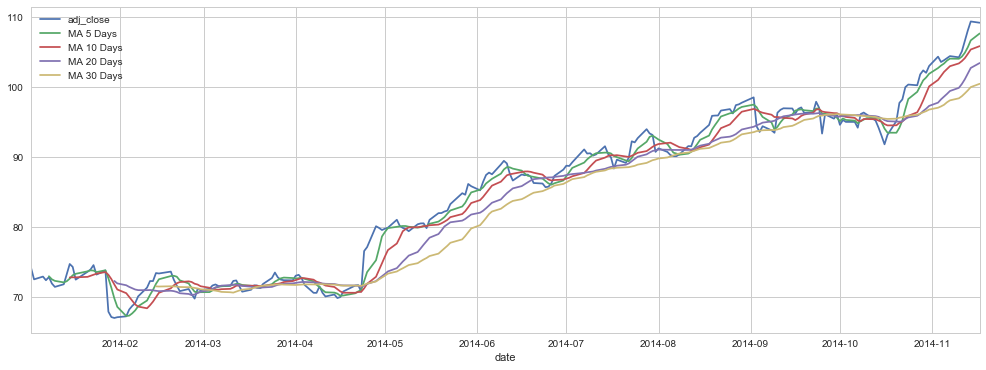

In [183]:
#FULL[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][:200].plot(figsize=(17,8))
#CDZI[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][:200].plot(figsize=(17,6))
AAPL[['date','adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][0:222].plot(x='date',figsize=(17,6))

In [166]:
###These are another solutions
#ma_day = [5, 10,20,30]
#for stock in stock_list:
#    for ma in ma_day:
#        colums_name='MA %s Days' % (str(ma))
#        stock_col = globals()[stock]
#        stock_col[colums_name] = Series.rolling(stock_col['adj_close'],ma).mean()

#GOOG_Sub = GOOG[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][(GOOG['date']>=dt(2016,2,1).date())]
#GOOG[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']].plot(figsize=(10,4))
#AAPL[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][(AAPL['date']>=dt(2016,2,1).date())].plot(figsize=(10,4))
#AAPL[['date','adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days','Upper BollingerBand','Lower BollingerBand']].plot(x='date',figsize=(10,6))

In [169]:
#This function is to get the stocks very day meeting requirement on the max date in the dateset
def model1_signal(stock_list, ma1=5,ma2=10,ma3=20,ma4=30,cci_n=20,bband_n=30):
    for stock in stock_list:
        stock_df = globals()[stock]
        stock_df['signal'] = 0
        for i in stock_df.index:
            name1='MA '+ str(ma1) +' Days'
            p1 = stock_df[name1][i]
            name2='MA '+ str(ma2) +' Days'
            p2 = stock_df[name2][i]
            name3='MA '+ str(ma3) +' Days'
            p3 = stock_df[name3][i]
            name4='MA '+ str(ma4) +' Days'
            p4 = stock_df[name4][i]
            name_cci = 'CCI_' + str(cci_n)
            p_cci = stock_df[name_cci][i]
            p_bband_upper = stock_df['Upper BollingerBand'][i]
            p_bband_lower = stock_df['Lower BollingerBand'][i]
            if ((p1>p2)&(p2>p3)&(p3>p4)) & (p_cci>=100) & (stock_df['adj_close'][i] >= p_bband_upper):
                stock_df['signal'][i] = 1
                print(stock + ' at ' + str(i) + ' is ready for long!')
            elif ((p1<p2)&(p2<p3)&(p3<p4)) & (p_cci<=-100) & (stock_df['adj_close'][i] <= p_bband_lower):
                stock_df['signal'][i] = -1
                print(stock + ' at ' + str(i) + ' is ready for short!')
            else:
                pass
    print('Function applied!')
model1_signal(stock_list)

C:\pythonProgramming\tools\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AAPL at 79 is ready for long!
AAPL at 80 is ready for long!
AAPL at 81 is ready for long!
AAPL at 82 is ready for long!
AAPL at 106 is ready for long!
AAPL at 132 is ready for long!
AAPL at 142 is ready for long!
AAPL at 158 is ready for long!
AAPL at 159 is ready for long!
AAPL at 160 is ready for long!
AAPL at 161 is ready for long!
AAPL at 199 is ready for short!


C:\pythonProgramming\tools\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AAPL at 208 is ready for long!
AAPL at 210 is ready for long!
AAPL at 211 is ready for long!
AAPL at 279 is ready for long!
AAPL at 280 is ready for long!
AAPL at 281 is ready for long!
AAPL at 328 is ready for long!
AAPL at 329 is ready for long!
AAPL at 330 is ready for long!
AAPL at 349 is ready for long!
AAPL at 374 is ready for short!
AAPL at 380 is ready for short!
AAPL at 381 is ready for short!
AAPL at 398 is ready for short!
AAPL at 399 is ready for short!
AAPL at 400 is ready for short!
AAPL at 401 is ready for short!
AAPL at 412 is ready for short!
AAPL at 413 is ready for short!
AAPL at 414 is ready for short!
AAPL at 460 is ready for long!
AAPL at 462 is ready for long!
AAPL at 463 is ready for long!
AAPL at 492 is ready for short!
AAPL at 494 is ready for short!
AAPL at 495 is ready for short!
AAPL at 496 is ready for short!
AAPL at 497 is ready for short!
AAPL at 506 is ready for short!
AAPL at 507 is ready for short!
AAPL at 508 is ready for short!
AAPL at 545 is ready 

In [186]:
stock1 = AAPL
stock1[(stock1['signal'] == 1) | (stock1['signal'] == -1)]

,ticker,date,open,high,low,close,volume,adj_close,MA 5 Days,MA 10 Days,MA 20 Days,MA 30 Days,CCI_20,Upper BollingerBand,Lower BollingerBand,signal
79,AAPL,2014-04-28,572.800026,595.749977,572.549980,594.090019,167371400.0,80.080790,75.222751,72.857221,72.229477,72.188184,181.937059,76.652560,67.723808,1
80,AAPL,2014-04-29,593.739998,595.979996,589.509995,592.329979,84344400.0,79.843544,76.857282,73.809552,72.604142,72.482892,164.011252,77.723185,67.242599,1
81,AAPL,2014-04-30,592.639999,599.430008,589.799988,590.089981,114160200.0,79.541602,78.618792,74.781834,72.930617,72.746598,139.748363,78.572844,66.920351,1
82,AAPL,2014-05-01,591.999985,594.799995,586.360016,591.480026,61012000.0,79.728974,79.257994,75.758698,73.260395,73.017178,113.498293,79.356668,66.677687,1
106,AAPL,2014-06-05,646.199997,649.370003,642.610008,647.349983,75951400.0,87.747384,86.516876,85.365526,83.048662,81.821591,115.109883,87.708029,75.935153,1
132,AAPL,2014-07-14,95.860001,96.889999,95.650002,96.449997,42810000.0,91.515634,90.604750,89.891223,88.287683,88.053771,117.352258,91.499014,84.608529,1
142,AAPL,2014-07-28,97.820000,99.239998,97.550003,99.019997,55318000.0,93.954154,92.157053,90.822035,90.356629,89.132467,154.315812,93.517517,84.747417,1
158,AAPL,2014-08-19,99.410004,100.680000,99.320000,100.529999,69399000.0,95.861367,93.908478,92.312219,92.169166,91.441479,147.556020,94.919029,87.963929,1
159,AAPL,2014-08-20,100.440002,101.089996,99.949997,100.570000,52699000.0,95.899510,94.543550,92.891983,92.353252,91.621134,135.798836,95.439685,87.802583,1
160,AAPL,2014-08-21,100.570000,100.940002,100.110001,100.580002,33478000.0,95.909048,95.130943,93.473655,92.545406,91.812177,117.388868,95.896168,87.728185,1
